# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 3, #degree
        'n': 5, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 5,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 1000,
        'noise': 0.1,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'border_min': 0.2, #needs to be between 0 and (x_max-x_min)/2
        'border_max': 0.4,
        'lower_degree_prob': 0.5,
        'a_zero_prob': 0.25,
        'a_random_prob': 0.1,      
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 1000,
                
        'interpretation_net_output_monomials': 5, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': False,
        'inet_training_without_noise': True, #dataset size without noise hardcoded to 50k in generate_paths
        'sparse_poly_representation_version': 1, #(1, 2); 1=old, 2=new

        'evaluate_with_real_function': False, #False
        'consider_labels_training': False, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        
        'symbolic_metamodeling_evaluation': False,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        'symbolic_regression_evaluation': True,
        'per_network_evaluation': False,
    },
    'computation':{
        'n_jobs': 10,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex, clear_output



In [4]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [5]:
from utilities.utility_functions import flatten, rec_gen, gen_monomial_identifier_list

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)     
        
    list_of_monomial_identifiers = []
    for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
        if np.sum(monomial_identifier) <= d:
            if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
                list_of_monomial_identifiers.append(monomial_identifier)        
else:
    variable_list = ['x'+ str(i) for i in range(n)]
    list_of_monomial_identifiers = gen_monomial_identifier_list(variable_list, d, n)
            
print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 56
[[3, 0, 0, 0, 0], [2, 1, 0, 0, 0], [2, 0, 1, 0, 0], [2, 0, 0, 1, 0], [2, 0, 0, 0, 1], [2, 0, 0, 0, 0], [1, 2, 0, 0, 0], [1, 1, 1, 0, 0], [1, 1, 0, 1, 0], [1, 1, 0, 0, 1], [1, 1, 0, 0, 0], [1, 0, 2, 0, 0], [1, 0, 1, 1, 0], [1, 0, 1, 0, 1], [1, 0, 1, 0, 0], [1, 0, 0, 2, 0], [1, 0, 0, 1, 1], [1, 0, 0, 1, 0], [1, 0, 0, 0, 2], [1, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 3, 0, 0, 0], [0, 2, 1, 0, 0], [0, 2, 0, 1, 0], [0, 2, 0, 0, 1], [0, 2, 0, 0, 0], [0, 1, 2, 0, 0], [0, 1, 1, 1, 0], [0, 1, 1, 0, 1], [0, 1, 1, 0, 0], [0, 1, 0, 2, 0], [0, 1, 0, 1, 1], [0, 1, 0, 1, 0], [0, 1, 0, 0, 2], [0, 1, 0, 0, 1], [0, 1, 0, 0, 0], [0, 0, 3, 0, 0], [0, 0, 2, 1, 0], [0, 0, 2, 0, 1], [0, 0, 2, 0, 0], [0, 0, 1, 2, 0], [0, 0, 1, 1, 1], [0, 0, 1, 1, 0], [0, 0, 1, 0, 2], [0, 0, 1, 0, 1], [0, 0, 1, 0, 0], [0, 0, 0, 3, 0], [0, 0, 0, 2, 1], [0, 0, 0, 2, 0], [0, 0, 0, 1, 2], [0, 0, 0, 1, 1], [0, 0, 0, 1, 0], [0, 0, 0, 0, 3], [0, 0, 0, 0, 2], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0]]


In [6]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials'] if config['i_net']['sparse_poly_representation_version'] == 1 else config['data']['n']*(config['data']['d']+1)*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']  
print('Output Shape: ', config['i_net']['interpretation_net_output_shape'])

transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

Output Shape:  285


In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_285_drop0.25e500b256_custom/lnets_1000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_5_d_3_negd_0_prob_0_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0.1bmin0.2bmax0.4lowd0.5azero0.25arand0.1
lnets_1000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_5_d_3_negd_0_prob_0_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0.1bmin0.2bmax0.4lowd0.5azero0.25arand0.1


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [9]:
def load_lambda_nets(index, no_noise=False):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path_identifier_lambda_net_data_loading = None 
                
    if no_noise==True:
        path_identifier_lambda_net_data_loading = generate_paths(path_type='interpretation_net_no_noise')['path_identifier_lambda_net_data']
    else:
        path_identifier_lambda_net_data_loading = path_identifier_lambda_net_data 
        
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [10]:
#LOAD DATA
if inet_training_without_noise:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list_without_noise = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1, no_noise=True) for i in epochs_save_range_lambda)  
    del parallel
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
else:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  5.5min finished
[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    8.6s finished


## Data Inspection

In [11]:
lambda_net_dataset.as_pandas().head()

seed  30000-target  21000-target  20100-target  20010-target  \
521  1373158606         0.000         0.000         0.000         0.000   
737  1373158606         0.000         0.000         0.000         0.000   
740  1373158606         0.000         0.000         0.000         0.000   
660  1373158606         0.000         0.000         0.000         0.000   
411  1373158606         0.000         0.000        -0.597         0.000   

     20001-target  20000-target  12000-target  11100-target  11010-target  \
521         0.000         0.000         0.000         0.000         0.000   
737         0.000         0.000         0.733         0.000         0.000   
740         0.000         0.000         0.000         0.000         0.000   
660         0.000         0.000         0.000         0.000         0.000   
411         0.000         0.000        -0.446         0.000         0.000   

     11001-target  11000-target  10200-target  10110-target  10101-target  \
521         0.000         0.000         0.000         0.000         0.000   
737         0.000         0.000         0.000         0.000         0.000   
740         0.000         0.000         0.000        -0.111         0.000   
660        -0.030         0.000         0.000         0.000         0.000   
411         0.000         0.000         0.000         0.000         0.000   

     10100-target  10020-target  10011-target  10010-target  10002-target  \
521         0.000        -0.190         0.000         0.000         0.000   
737         0.000         0.000         0.000         0.000         0.000   
740         0.000         0.000         0.000         0.000         0.000   
660         0.000         0.000         0.000         0.000         0.000   
411         0.000         0.000         0.000         0.000         0.000   

     10001-target  10000-target  03000-target  02100-target  02010-target  \
521         0.000         0.000         0.000         0.000         0.000   
737         0.000         0.000         0.000         0.000         0.000   
740         0.000         0.000         0.000         0.000         0.159   
660         0.000         0.000         0.999         0.000         0.136   
411         0.000         0.000         0.000         0.000         0.000   

     02001-target  02000-target  01200-target  01110-target  01101-target  \
521         0.000         0.000         0.000         0.000         0.000   
737         0.000         0.000        -0.921        -0.739         0.000   
740        -0.106         0.000        -0.212         0.000         0.000   
660         0.000         0.000         0.000         0.000         0.000   
411         0.000         0.000         0.000         0.000         0.000   

     01100-target  01020-target  01011-target  01010-target  01002-target  \
521         0.000         0.000         0.000         0.000         0.000   
737         0.000         0.000         0.000         0.000         0.000   
740         0.000         0.000         0.000         0.000         0.000   
660         0.000         0.442         0.000         0.000         0.000   
411        -0.353        -0.043         0.000         0.000         0.000   

     01001-target  01000-target  00300-target  00210-target  00201-target  \
521         0.000         0.000         0.000         0.988         0.000   
737         0.699         0.000         0.000         0.000         0.000   
740         0.000         0.000         0.000         0.000         0.000   
660        -0.471         0.000         0.000         0.000         0.000   
411         0.000         0.000         0.000         0.000         0.000   

     00200-target  00120-target  00111-target  00110-target  00102-target  \
521         0.000        -0.388         0.000         0.000        -0.400   
737         0.000         0.000         0.000         0.000         0.000   
740         0.000         0.000         0.000         0.000         0.000   
660        

In [12]:
lambda_net_dataset.as_pandas().describe()

seed  30000-target  21000-target  20100-target  20010-target  \
count       1000.000      1000.000      1000.000      1000.000      1000.000   
mean  1373158606.000        -0.000         0.000         0.003        -0.008   
std            0.000         0.202         0.181         0.169         0.176   
min   1373158606.000        -0.996        -0.984        -0.974        -0.995   
25%   1373158606.000         0.000         0.000         0.000         0.000   
50%   1373158606.000         0.000         0.000         0.000         0.000   
75%   1373158606.000         0.000         0.000         0.000         0.000   
max   1373158606.000         0.981         0.974         0.942         0.984   

       20001-target  20000-target  12000-target  11100-target  11010-target  \
count      1000.000      1000.000      1000.000      1000.000      1000.000   
mean         -0.004        -0.000         0.005        -0.003         0.007   
std           0.180         0.187         0.184         0.179         0.159   
min          -0.974        -0.976        -0.989        -0.995        -0.977   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           0.955         0.987         0.995         0.991         0.999   

       11001-target  11000-target  10200-target  10110-target  10101-target  \
count      1000.000      1000.000      1000.000      1000.000      1000.000   
mean          0.013         0.000        -0.002        -0.001         0.002   
std           0.164         0.163         0.174         0.156         0.170   
min          -0.980        -0.999        -0.990        -0.980        -0.969   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           0.972         0.955         0.994         0.940         0.995   

       10100-target  10020-target  10011-target  10010-target  10002-target  \
count      1000.000      1000.000      1000.000      1000.000      1000.000   
mean         -0.008         0.002         0.001        -0.001         0.000   
std           0.193         0.165         0.169         0.159         0.152   
min          -0.979        -0.959        -0.985        -0.961        -0.987   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           0.995         0.957         0.930         0.995         0.992   

       10001-target  10000-target  03000-target  02100-target  02010-target  \
count      1000.000      1000.000      1000.000      1000.000      1000.000   
mean         -0.001        -0.001        -0.004        -0.002         0.005   
std           0.142         0.173         0.161         0.175         0.175   
min          -0.998        -0.981        -0.979        -0.997        -0.987   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           0.999         0.997         0.999         0.967         0.954   

       02001-target  02000-target  01200-target  01110-target  01101-target  \
count      1000.000      1000.000      1000.000      1000.000      1000.000   
mean         -0.005         0.006         0.002         0.002         0.000   
std           0.159         0.173         0.166         0.175         0.186   
min          -1.000        -0.977        -0.999        -0.988        -0.964   
25%           0.000         0.000         0.000     

In [13]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[9.41681430e-02, 3.72841132e-01, 6.39588164e-01, 4.31336366e-01,
        8.56509560e-01],
       [7.96713547e-01, 3.73376287e-01, 2.66019144e-01, 5.03038595e-01,
        7.23443984e-01],
       [5.71495801e-01, 2.77435866e-01, 8.10306934e-01, 4.42926452e-01,
        6.03366085e-01],
       [1.95610034e-01, 7.27693240e-01, 1.76130307e-01, 6.94681505e-01,
        9.26936666e-01],
       [7.98376944e-01, 8.60156528e-01, 2.02660185e-01, 4.99962330e-01,
        8.25956287e-01],
       [8.89907347e-01, 6.92556560e-01, 4.23117334e-01, 3.95357490e-01,
        4.34007680e-01],
       [7.99697868e-02, 1.41172526e-01, 2.86208851e-01, 7.98252916e-01,
        1.44731288e-01],
       [8.06024056e-02, 8.76677670e-01, 1.23288125e-01, 5.51061324e-01,
        8.09642353e-01],
       [9.47447594e-01, 3.43203002e-01, 6.69193460e-01, 4.65364961e-01,
        8.87984698e-01],
       [7.66968762e-01, 7.97805359e-01, 3.51139847e-01, 1.41215150e-04,
        6.35638876e-01]])

In [14]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[-0.90548266],
       [-0.8484129 ],
       [-0.53468783],
       [-1.00101101],
       [-0.86938546],
       [-0.37448101],
       [-0.04800994],
       [-0.74919738],
       [-0.92336592],
       [-0.59763657]])

## Generate Datasets for Interpretation-Net training

In [15]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []


if inet_training_without_noise:
   
    for lambda_net_dataset, lambda_net_dataset_without_noise in zip(lambda_net_dataset_list, lambda_net_dataset_list_without_noise):
        if inet_holdout_seed_evaluation:
            raise SystemExit('Holdout Evaluation not implemented with inet training without noise')
            
        else:
            lambda_net_train_dataset = lambda_net_dataset_without_noise

            lambda_net_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_dataset_list_without_noise
        
else:

    for lambda_net_dataset in lambda_net_dataset_list:

        if inet_holdout_seed_evaluation:

            complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

            random.seed(RANDOM_SEED)

            if isinstance(test_size, float):
                test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))

            test_seeds = random.sample(complete_seed_list, test_size)
            lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

            random.seed(RANDOM_SEED)
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
            lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

            train_seeds = complete_seed_list
            lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset
        else:

            lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_train_with_valid_dataset


del lambda_net_dataset_list

In [16]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(50000, 345)

In [17]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(900, 345)

In [18]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 345)

In [19]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  30000-target  21000-target  20100-target  20010-target  \
33553  1373158606         0.000         0.000         0.000         0.000   
9427   1373158606         0.000         0.000         0.000         0.000   
199    1373158606         0.000         0.000         0.000         0.000   
12447  1373158606        -0.196         0.000         0.000         0.000   
39489  1373158606         0.000         0.000         0.000         0.000   

       20001-target  20000-target  12000-target  11100-target  11010-target  \
33553         0.000         0.003         0.000         0.000         0.000   
9427          0.000         0.000         0.000         0.000        -0.526   
199           0.000         0.000         0.000         0.000         0.000   
12447         0.000         0.000         0.000         0.000         0.000   
39489         0.000         0.000         0.000         0.000         0.000   

       11001-target  11000-target  10200-target  10110-target  10101-target  \
33553         0.000         0.000         0.000         0.000         0.000   
9427          0.000         0.000         0.000         0.000         0.000   
199           0.000         0.000        -0.433         0.334         0.000   
12447         0.000        -0.764         0.000         0.000         0.000   
39489         0.000         0.000        -0.658         0.000         0.000   

       10100-target  10020-target  10011-target  10010-target  10002-target  \
33553         0.833         0.000         0.000         0.000         0.000   
9427          0.000         0.000         0.000         0.000         0.000   
199           0.000         0.343         0.000         0.000         0.000   
12447         0.000         0.000         0.000         0.000         0.000   
39489         0.000         0.000         0.000         0.000         0.000   

       10001-target  10000-target  03000-target  02100-target  02010-target  \
33553         0.000         0.000         0.000         0.000         0.000   
9427          0.000         0.000         0.000         0.000         0.000   
199           0.000         0.000         0.000         0.000         0.000   
12447         0.000         0.000         0.000         0.000         0.000   
39489         0.000         0.000         0.000         0.290         0.000   

       02001-target  02000-target  01200-target  01110-target  01101-target  \
33553         0.000         0.000         0.000         0.000         0.000   
9427          0.000         0.000         0.000         0.000         0.000   
199           0.000         0.000         0.000         0.000         0.000   
12447         0.000         0.000         0.000         0.000         0.000   
39489         0.000         0.000         0.856        -0.495         0.000   

       01100-target  01020-target  01011-target  01010-target  01002-target  \
33553         0.000         0.000         0.000         0.000         0.851   
9427          0.000         0.000         0.000         0.000         0.000   
199           0.000        -0.828        -0.028         0.000         0.000   
12447         0.000        -0.808         0.000         0.000         0.000   
39489         0.000         0.000         0.000         0.000         0.000   

       01001-target  01000-target  00300-target  00210-target  00201-target  \
33553         0.000         0.000         0.000         0.000         0.000   
9427          0.000         0.000         0.000         0.000         0.000   
199           0.000         0.000         0.000         0.000         0.000   
12447         0.000         0.000         0.000         0.000         0.000   
39489         0.000         0.000         0.000         0.000         0.000   

       00200-target  00120-target  00111-target  00110-target  00102-target  \
33553         0.000         0.000         0.000         0.000         0.000   
9427          0.000         0.817         0.000         0.052      

In [20]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  30000-target  21000-target  20100-target  20010-target  \
123  1373158606         0.000         0.000         0.000         0.000   
274  1373158606         0.000         0.000         0.000         0.000   
600  1373158606         0.000         0.000         0.000         0.000   
519  1373158606         0.000        -0.024         0.000         0.000   
225  1373158606         0.000         0.000         0.000         0.000   

     20001-target  20000-target  12000-target  11100-target  11010-target  \
123         0.860         0.000         0.000         0.000         0.000   
274         0.000         0.000         0.000         0.000         0.000   
600         0.000        -0.110         0.000         0.000         0.000   
519         0.000         0.000         0.000         0.322         0.000   
225         0.000         0.000         0.000         0.000         0.000   

     11001-target  11000-target  10200-target  10110-target  10101-target  \
123         0.000         0.000         0.000         0.000         0.000   
274         0.000         0.000         0.000         0.000         0.000   
600         0.000         0.000         0.000         0.000         0.000   
519         0.000         0.000        -0.288         0.000         0.000   
225         0.000         0.000         0.000         0.000        -0.443   

     10100-target  10020-target  10011-target  10010-target  10002-target  \
123        -0.924         0.000         0.000         0.000         0.000   
274        -0.203         0.000         0.000         0.000         0.000   
600         0.000         0.000         0.000         0.000         0.000   
519         0.000         0.000         0.000         0.000         0.000   
225         0.000         0.000         0.000         0.000         0.000   

     10001-target  10000-target  03000-target  02100-target  02010-target  \
123         0.000         0.000         0.000        -0.168         0.000   
274         0.000         0.000        -0.979         0.000         0.000   
600         0.000         0.000         0.000        -0.994         0.000   
519         0.000         0.000         0.000         0.000         0.000   
225         0.000         0.000         0.000         0.000         0.000   

     02001-target  02000-target  01200-target  01110-target  01101-target  \
123         0.000         0.000         0.000         0.000         0.000   
274        -0.992         0.000         0.000         0.000         0.000   
600         0.000         0.000         0.000         0.000         0.000   
519         0.000         0.000         0.000         0.000         0.000   
225        -0.380         0.000         0.000         0.000         0.000   

     01100-target  01020-target  01011-target  01010-target  01002-target  \
123         0.000         0.000         0.000         0.000         0.000   
274         0.000         0.000         0.000         0.000         0.000   
600        -0.747         0.000         0.000         0.000         0.000   
519         0.000        -0.677         0.000         0.899         0.000   
225         0.000         0.000         0.000         0.000         0.000   

     01001-target  01000-target  00300-target  00210-target  00201-target  \
123         0.000         0.000         0.000         0.000         0.000   
274         0.000         0.000         0.778         0.000         0.000   
600         0.000         0.000         0.000         0.000         0.000   
519         0.000         0.000         0.000         0.000         0.000   
225         0.000        -0.569         0.000         0.000         0.000   

     00200-target  00120-target  00111-target  00110-target  00102-target  \
123         0.000         0.000         0.000         0.000         0.000   
274         0.000         0.000         0.000        -0.537         0.000   
600         0.000         0.000         0.000         0.000         0.000   
519        

In [21]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  30000-target  21000-target  20100-target  20010-target  \
666  1373158606         0.000         0.000         0.000         0.000   
129  1373158606         0.000         0.000         0.000         0.000   
784  1373158606         0.000         0.272         0.000         0.000   
152  1373158606         0.000         0.000         0.000         0.000   
920  1373158606         0.000         0.000         0.000         0.000   

     20001-target  20000-target  12000-target  11100-target  11010-target  \
666         0.303         0.000         0.000         0.000         0.000   
129         0.000         0.000         0.000         0.000         0.000   
784         0.000         0.000         0.000         0.426         0.000   
152         0.000         0.000         0.000         0.000         0.000   
920         0.000        -0.493         0.000         0.000         0.000   

     11001-target  11000-target  10200-target  10110-target  10101-target  \
666         0.000         0.000         0.000         0.000         0.000   
129         0.000        -0.323         0.000         0.000         0.000   
784         0.000         0.000         0.000         0.000         0.000   
152         0.000         0.000         0.000         0.000         0.000   
920         0.000         0.000         0.000         0.000         0.000   

     10100-target  10020-target  10011-target  10010-target  10002-target  \
666         0.000         0.000         0.000         0.566         0.000   
129         0.000         0.000         0.000         0.000         0.000   
784         0.000         0.000         0.000         0.000         0.000   
152         0.000         0.000         0.000         0.000         0.000   
920        -0.975         0.000         0.000         0.000         0.000   

     10001-target  10000-target  03000-target  02100-target  02010-target  \
666         0.000         0.000         0.000         0.000         0.000   
129         0.064         0.000         0.000         0.000         0.000   
784         0.000         0.000         0.000         0.000         0.000   
152         0.000         0.000         0.000         0.000         0.000   
920        -0.275         0.000        -0.351         0.000         0.000   

     02001-target  02000-target  01200-target  01110-target  01101-target  \
666         0.000         0.000         0.000         0.000         0.000   
129         0.000         0.000         0.000         0.000        -0.469   
784         0.000         0.000         0.000         0.000         0.000   
152         0.000         0.000         0.000         0.000         0.172   
920         0.000         0.000         0.000         0.000         0.000   

     01100-target  01020-target  01011-target  01010-target  01002-target  \
666         0.000         0.000         0.000         0.000         0.000   
129         0.000         0.000         0.105         0.000         0.000   
784        -0.716         0.000         0.000         0.000         0.000   
152         0.000         0.000         0.000         0.000         0.000   
920         0.000         0.000         0.000         0.000         0.000   

     01001-target  01000-target  00300-target  00210-target  00201-target  \
666         0.000         0.000         0.000         0.101         0.000   
129         0.000         0.000         0.000        -0.619         0.000   
784         0.000         0.000         0.000         0.000         0.000   
152         0.000         0.000         0.000        -0.809         0.000   
920         0.000         0.000         0.000         0.000         0.000   

     00200-target  00120-target  00111-target  00110-target  00102-target  \
666         0.000         0.000         0.000         0.000         0.000   
129         0.000         0.000         0.000         0.000         0.000   
784         0.641         0.000         0.000         0.000         0.000   
152        

## Interpretation Network Training

In [22]:
#%load_ext autoreload

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Epoch 1/500
196/196 [==============================] - 105s 496ms/step - loss: 0.2649 - r2_inet_lambda_fv_loss: 1.0468 - val_loss: 0.2125 - val_r2_inet_lambda_fv_loss: 0.3586
Epoch 2/500
196/196 [==============================] - 91s 466ms/step - loss: 0.2204 - r2_inet_lambda_fv_loss: 0.3732 - val_loss: 0.2077 - val_r2_inet_lambda_fv_loss: 0.2807
Epoch 3/500
196/196 [==============================] - 92s 470ms/step - loss: 0.2137 - r2_inet_lambda_fv_loss: 0.2699 - val_loss: 0.2028 - val_r2_inet_lambda_fv_loss: 0.1950
Epoch 4/500
196/196 [==============================] - 93s 473ms/step - loss: 0.2088 - r2_inet_lambda_fv_loss: 0.1869 - val_loss: 0.1987 - val_r2_inet_lambda_fv_loss: 0.1270
Epoch 5/500
196/196 [==============================] - 92s 468ms/step - loss: 0.2073 - r2_inet_lambda_fv_loss: 0.1538 - val_loss: 0.2019 - val_r2_inet_lambda_fv_loss: 0.1470
Epoch

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



196/196 [==============================] - 90s 461ms/step - loss: 0.1821 - r2_inet_lambda_fv_loss: -0.0323 - val_loss: 0.1775 - val_r2_inet_lambda_fv_loss: -0.0303
Epoch 54/500
196/196 [==============================] - 91s 462ms/step - loss: 0.1814 - r2_inet_lambda_fv_loss: -0.0204 - val_loss: 0.1775 - val_r2_inet_lambda_fv_loss: -0.0398
Epoch 55/500
196/196 [==============================] - 91s 466ms/step - loss: 0.1805 - r2_inet_lambda_fv_loss: -0.0313 - val_loss: 0.1781 - val_r2_inet_lambda_fv_loss: -0.0029
Epoch 56/500
196/196 [==============================] - 91s 464ms/step - loss: 0.1795 - r2_inet_lambda_fv_loss: -0.0618 - val_loss: 0.1793 - val_r2_inet_lambda_fv_loss: 0.0103
Epoch 57/500
196/196 [==============================] - 91s 464ms/step - loss: 0.1798 - r2_inet_lambda_fv_loss: -0.0425 - val_loss: 0.1770 - val_r2_inet_lambda_fv_loss: -0.0284
Epoch 58/500
196/196 [==============================] - 91s 463ms/step - loss: 0.1790 - r2_inet_lambda_fv_loss: -0.0733 - val_los

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



196/196 [==============================] - 91s 464ms/step - loss: 0.1724 - r2_inet_lambda_fv_loss: -0.1152 - val_loss: 0.1699 - val_r2_inet_lambda_fv_loss: -0.1009
Epoch 80/500
196/196 [==============================] - 91s 464ms/step - loss: 0.1702 - r2_inet_lambda_fv_loss: -0.1476 - val_loss: 0.1679 - val_r2_inet_lambda_fv_loss: -0.1203
Epoch 81/500
196/196 [==============================] - 90s 460ms/step - loss: 0.1711 - r2_inet_lambda_fv_loss: -0.1135 - val_loss: 0.1696 - val_r2_inet_lambda_fv_loss: -0.1063
Epoch 82/500
196/196 [==============================] - 91s 465ms/step - loss: 0.1701 - r2_inet_lambda_fv_loss: -0.1401 - val_loss: 0.1701 - val_r2_inet_lambda_fv_loss: -0.0980
Epoch 83/500
196/196 [==============================] - 91s 462ms/step - loss: 0.1704 - r2_inet_lambda_fv_loss: -0.1370 - val_loss: 0.1687 - val_r2_inet_lambda_fv_loss: -0.1119
Epoch 84/500
196/196 [==============================] - 91s 464ms/step - loss: 0.1704 - r2_inet_lambda_fv_loss: -0.1244 - val_lo

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



196/196 [==============================] - 91s 467ms/step - loss: 0.1674 - r2_inet_lambda_fv_loss: -0.1606 - val_loss: 0.1662 - val_r2_inet_lambda_fv_loss: -0.1118
Epoch 104/500
196/196 [==============================] - 91s 465ms/step - loss: 0.1673 - r2_inet_lambda_fv_loss: -0.1580 - val_loss: 0.1656 - val_r2_inet_lambda_fv_loss: -0.1226
Epoch 105/500
196/196 [==============================] - 92s 470ms/step - loss: 0.1664 - r2_inet_lambda_fv_loss: -0.1522 - val_loss: 0.1648 - val_r2_inet_lambda_fv_loss: -0.1099
Epoch 106/500
196/196 [==============================] - 91s 464ms/step - loss: 0.1668 - r2_inet_lambda_fv_loss: -0.1621 - val_loss: 0.1662 - val_r2_inet_lambda_fv_loss: -0.0892
Epoch 107/500
196/196 [==============================] - 91s 465ms/step - loss: 0.1662 - r2_inet_lambda_fv_loss: -0.1880 - val_loss: 0.1683 - val_r2_inet_lambda_fv_loss: -0.0648
Epoch 108/500
196/196 [==============================] - 92s 469ms/step - loss: 0.1685 - r2_inet_lambda_fv_loss: -0.1392 - v

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



196/196 [==============================] - 91s 466ms/step - loss: 0.1628 - r2_inet_lambda_fv_loss: -0.2043 - val_loss: 0.1605 - val_r2_inet_lambda_fv_loss: -0.1706
Epoch 130/500
196/196 [==============================] - 92s 467ms/step - loss: 0.1612 - r2_inet_lambda_fv_loss: -0.2253 - val_loss: 0.1611 - val_r2_inet_lambda_fv_loss: -0.1728
Epoch 131/500
196/196 [==============================] - 91s 465ms/step - loss: 0.1609 - r2_inet_lambda_fv_loss: -0.2365 - val_loss: 0.1613 - val_r2_inet_lambda_fv_loss: -0.1656
Epoch 132/500
196/196 [==============================] - 91s 465ms/step - loss: 0.1612 - r2_inet_lambda_fv_loss: -0.2110 - val_loss: 0.1610 - val_r2_inet_lambda_fv_loss: -0.1702
Epoch 133/500
196/196 [==============================] - 91s 467ms/step - loss: 0.1598 - r2_inet_lambda_fv_loss: -0.2426 - val_loss: 0.1618 - val_r2_inet_lambda_fv_loss: -0.1610
Epoch 134/500
196/196 [==============================] - 91s 466ms/step - loss: 0.1614 - r2_inet_lambda_fv_loss: -0.2272 - v

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



196/196 [==============================] - 91s 467ms/step - loss: 0.1568 - r2_inet_lambda_fv_loss: -0.2579 - val_loss: 0.1556 - val_r2_inet_lambda_fv_loss: -0.1920
Epoch 154/500
196/196 [==============================] - 91s 464ms/step - loss: 0.1563 - r2_inet_lambda_fv_loss: -0.2535 - val_loss: 0.1566 - val_r2_inet_lambda_fv_loss: -0.1851
Epoch 155/500
196/196 [==============================] - 92s 468ms/step - loss: 0.1569 - r2_inet_lambda_fv_loss: -0.2546 - val_loss: 0.1556 - val_r2_inet_lambda_fv_loss: -0.1887
Epoch 156/500
196/196 [==============================] - 92s 468ms/step - loss: 0.1563 - r2_inet_lambda_fv_loss: -0.2802 - val_loss: 0.1555 - val_r2_inet_lambda_fv_loss: -0.1986
Epoch 157/500
196/196 [==============================] - 91s 464ms/step - loss: 0.1564 - r2_inet_lambda_fv_loss: -0.2525 - val_loss: 0.1561 - val_r2_inet_lambda_fv_loss: -0.1945
Epoch 158/500
196/196 [==============================] - 91s 466ms/step - loss: 0.1555 - r2_inet_lambda_fv_loss: -0.2665 - v

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



196/196 [==============================] - 42s 216ms/step - loss: 0.1500 - r2_inet_lambda_fv_loss: -0.2990 - val_loss: 0.1503 - val_r2_inet_lambda_fv_loss: -0.2391
Epoch 180/500
196/196 [==============================] - 43s 218ms/step - loss: 0.1496 - r2_inet_lambda_fv_loss: -0.3110 - val_loss: 0.1522 - val_r2_inet_lambda_fv_loss: -0.2261
Epoch 181/500
196/196 [==============================] - 43s 218ms/step - loss: 0.1495 - r2_inet_lambda_fv_loss: -0.3100 - val_loss: 0.1512 - val_r2_inet_lambda_fv_loss: -0.2270
Epoch 182/500
196/196 [==============================] - 43s 218ms/step - loss: 0.1487 - r2_inet_lambda_fv_loss: -0.3083 - val_loss: 0.1507 - val_r2_inet_lambda_fv_loss: -0.2250
Epoch 183/500
196/196 [==============================] - 42s 216ms/step - loss: 0.1499 - r2_inet_lambda_fv_loss: -0.3052 - val_loss: 0.1521 - val_r2_inet_lambda_fv_loss: -0.2100
Epoch 184/500
196/196 [==============================] - 43s 219ms/step - loss: 0.1498 - r2_inet_lambda_fv_loss: -0.2971 - v

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



196/196 [==============================] - 43s 220ms/step - loss: 0.1471 - r2_inet_lambda_fv_loss: -0.3352 - val_loss: 0.1482 - val_r2_inet_lambda_fv_loss: -0.2611
Epoch 203/500
196/196 [==============================] - 43s 219ms/step - loss: 0.1464 - r2_inet_lambda_fv_loss: -0.3378 - val_loss: 0.1493 - val_r2_inet_lambda_fv_loss: -0.2562
Epoch 204/500
196/196 [==============================] - 42s 217ms/step - loss: 0.1463 - r2_inet_lambda_fv_loss: -0.3451 - val_loss: 0.1467 - val_r2_inet_lambda_fv_loss: -0.2737
Epoch 205/500
196/196 [==============================] - 43s 219ms/step - loss: 0.1463 - r2_inet_lambda_fv_loss: -0.3397 - val_loss: 0.1484 - val_r2_inet_lambda_fv_loss: -0.2647
Epoch 206/500
196/196 [==============================] - 43s 217ms/step - loss: 0.1465 - r2_inet_lambda_fv_loss: -0.3462 - val_loss: 0.1482 - val_r2_inet_lambda_fv_loss: -0.2720
Epoch 207/500
196/196 [==============================] - 43s 218ms/step - loss: 0.1459 - r2_inet_lambda_fv_loss: -0.3437 - v

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



196/196 [==============================] - 88s 448ms/step - loss: 0.1461 - r2_inet_lambda_fv_loss: -0.3373 - val_loss: 0.1481 - val_r2_inet_lambda_fv_loss: -0.2631
Epoch 230/500
196/196 [==============================] - 88s 448ms/step - loss: 0.1456 - r2_inet_lambda_fv_loss: -0.3461 - val_loss: 0.1488 - val_r2_inet_lambda_fv_loss: -0.2623
Epoch 231/500
196/196 [==============================] - 87s 446ms/step - loss: 0.1456 - r2_inet_lambda_fv_loss: -0.3428 - val_loss: 0.1500 - val_r2_inet_lambda_fv_loss: -0.2528
Epoch 232/500
196/196 [==============================] - 88s 447ms/step - loss: 0.1462 - r2_inet_lambda_fv_loss: -0.3379 - val_loss: 0.1482 - val_r2_inet_lambda_fv_loss: -0.2679
Epoch 233/500
196/196 [==============================] - 88s 448ms/step - loss: 0.1457 - r2_inet_lambda_fv_loss: -0.3435 - val_loss: 0.1496 - val_r2_inet_lambda_fv_loss: -0.2565
Epoch 234/500
196/196 [==============================] - 87s 445ms/step - loss: 0.1461 - r2_inet_lambda_fv_loss: -0.3478 - v

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



196/196 [==============================] - 88s 449ms/step - loss: 0.1462 - r2_inet_lambda_fv_loss: -0.3351 - val_loss: 0.1481 - val_r2_inet_lambda_fv_loss: -0.2771
Training Time: 5:50:30
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------ LOADING MODELS -----------------------------------------------------
Loading Time: 0:00:01
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------
----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:  3.2min
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:  3.3min
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:  3.4min
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:  3.4min
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  3.4min
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:  6.0min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  6.0min
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:  6.1min
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed:  6.3min
[Parallel(n_jobs=10)]: Done  15 tasks      | elapsed:  

Symbolic Regression Optimization Time: 0:30:22
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


False


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


metamodel_poly
Exit <class 'KeyError'>
metamodel_functions
Exit <class 'KeyError'>
metamodel_functions_no_GD
Exit <class 'KeyError'>
symbolic_regression_functions


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    2.7s finished


[[ 1.09101809  0.79974275  0.32080853 ...  0.66628246  0.78157639
   0.63618873]
 [-0.16063459 -0.13738564 -0.3398367  ... -0.38114165 -0.41685961
  -0.02815121]
 [ 0.98673511  0.26030475  0.24660091 ...  0.77956736  0.5734244
   0.39399591]
 ...
 [-0.03161507 -0.04126538 -0.02423885 ... -0.0646446  -0.24288862
  -0.10833134]
 [ 0.22583836  0.01292333  0.01965427 ... -0.34552902 -0.19485021
   0.0038801 ]
 [ 0.12719071  0.01660789  0.13691629 ...  0.0488892   0.07104965
   0.59213424]]
[ 0.22583836  0.01292333  0.01965427 ... -0.34552902 -0.19485021
  0.0038801 ]
[ 0.22583836  0.01292333  0.01965427 ... -0.34552902 -0.19485021
  0.0038801 ]
per_network_polynomials
Exit <class 'KeyError'>
FV Calculation Time: 0:00:34
---------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_pol

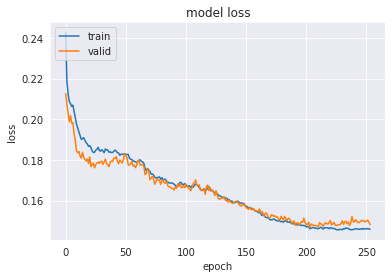

In [23]:
#%autoreload 2
(history_list, 

#scores_valid_list,
scores_test_list, 

#function_values_valid_list, 
function_values_test_list, 

#polynomial_dict_valid_list,
polynomial_dict_test_list,

#distrib_dict_valid_list,
distrib_dict_test_list,

model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)



## Evaluate Interpretation Net

In [24]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [25]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 176)]        0                                            
__________________________________________________________________________________________________
hidden1_512 (Dense)             (None, 512)          90624       input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 512)          0           hidden1_512[0][0]                
__________________________________________________________________________________________________
dropout1_0.25 (Dropout)         (None, 512)          0           activation1_relu[0][0]           
______________________________________________________________________________________________

In [26]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [27]:
scores_test_list[-1]

MAE  RMSE   MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN    NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN    NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN    NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN    NaN   
lambda_preds_VS_symbolic_regression_functions        NaN   NaN    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.089 0.133  7.509   
target_polynomials_VS_lstsq_target_polynomials     0.031 0.048  2.841   
target_polynomials_VS_inet_polynomials             0.266 0.381 24.353   
target_polynomials_VS_symbolic_regression_funct...   NaN   NaN    NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.093 0.137  3.536   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.275 0.391 32.082   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...   NaN   NaN    NaN   
lstsq_target_polynomials_VS_inet_polynomials       0.264 0.380 23.961   
lstsq_target_polynomials_VS_symbolic_regression...   NaN   NaN    NaN   
inet_polynomials_VS_symbolic_regression_functions    NaN   NaN    NaN   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
lambda_preds_VS_symbolic_regression_functions            NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.447   
target_polynomials_VS_lstsq_target_polynomials         0.809   
target_polynomials_VS_inet_polynomials                 0.196   
target_polynomials_VS_symbolic_regression_funct...       NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.424   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.188   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...       NaN   
lstsq_target_polynomials_VS_inet_polynomials           0.218   
lstsq_target_polynomials_VS_symbolic_regression...       NaN   
inet_polynomials_VS_symbolic_regression_functions        NaN   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
lambda_preds_VS_symbolic_regression_functions                       NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.000   
target_polynomials_VS_lstsq_target_polynomials                    0.110   
target_polynomials_VS_inet_polynomials                            0.000   
target_polynomials_VS_symbolic_regression_funct...                  NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials                 0.000   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...                  NaN   
lstsq_target_polynomials_VS_inet_polynomials                      0.000   
lstsq_target_polynomials_VS_symbolic_regression...                  NaN   
inet_polynomials_VS_symbolic_regression_functions                   NaN   

                                                    MAE FV  RMSE FV  MAPE FV  \
lambda_preds_VS_target_polynomials                   0.018    0.023    0.939   
lambda_preds_VS_lstsq_lambda_pred_polynomials        0.015    0.019    0.660   
lambda_preds_VS_lstsq_target_polynomials             0.018    0.023    0.977   
lambda_preds_VS_inet_polynomials                     0.146    0.189   11.127   
lambda_preds_VS_symbolic_regression_functions        0.104    0.143    3.632   
target_polynomials_VS_lstsq_lambda_pred_polynom...   0.012    0.017    0.357   
target_polynomials_VS_lstsq_target_polynomials       0.004    0.005    0.098   
target_polynomials

In [28]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.027 0.013 0.027 0.012   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.017 0.012 0.015 0.012   
lambda_preds_VS_lstsq_target_polynomials           0.026 0.013 0.027 0.012   
lambda_preds_VS_inet_polynomials                   0.264 0.107 0.159 0.077   
lambda_preds_VS_symbolic_regression_functions      0.147 0.090 0.127 0.055   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.022 0.008 0.023 0.007   
target_polynomials_VS_lstsq_target_polynomials     0.008 0.003 0.006 0.003   
target_polynomials_VS_inet_polynomials             0.262 0.106 0.159 0.077   
target_polynomials_VS_symbolic_regression_funct... 0.147 0.091 0.130 0.054   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.020 0.008 0.023 0.007   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.261 0.105 0.158 0.077   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.145 0.090 0.125 0.054   
lstsq_target_polynomials_VS_inet_polynomials       0.260 0.106 0.161 0.077   
lstsq_target_polynomials_VS_symbolic_regression... 0.146 0.091 0.132 0.054   
inet_polynomials_VS_symbolic_regression_functions  0.201 0.126 0.118 0.085   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.020 0.015 0.015 0.010   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.018 0.014 0.014 0.010   
lambda_preds_VS_lstsq_target_polynomials           0.020 0.015 0.015 0.010   
lambda_preds_VS_inet_polynomials                   0.144 0.165 0.081 0.125   
lambda_preds_VS_symbolic_regression_functions      0.148 0.062 0.083 0.065   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.013 0.009 0.011 0.006   
target_polynomials_VS_lstsq_target_polynomials     0.005 0.004 0.001 0.002   
target_polynomials_VS_inet_polynomials             0.143 0.165 0.082 0.125   
target_polynomials_VS_symbolic_regression_funct... 0.147 0.060 0.084 0.063   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.013 0.009 0.011 0.006   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.144 0.164 0.079 0.125   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.146 0.059 0.080 0.064   
lstsq_target_polynomials_VS_inet_polynomials       0.144 0.165 0.082 0.125   
lstsq_target_polynomials_VS_symbolic_regression... 0.148 0.060 0.083 0.063   
inet_polynomials_VS_symbolic_regression_functions  0.140 0.172 0.053 0.095   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.020 0.013 0.015 0.017   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.016 0.013 0.014 0.012   
lambda_preds_VS_lstsq_target_polynomials           0.019 0.014 0.015 0.017   
lambda_preds_VS_inet_polynomials                   0.181 0.193 0.101 0.075   
lambda_preds_VS_symbolic_regression_functions      0.136 0.102 0.066 0.080   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.015 0.009 0.009 0.013   
target_polynomials_VS_lstsq_target_polynomials     0.006 0.003 0.002 0.001   
target_polynomials_VS_inet_polynomials             0.184 0.191 0.098 0.075   
target_polynomials_VS_symbolic_regression_funct... 0.136 0.101 0.065 0.079   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.013 0.010 0.009 0.014   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.181 0.193 0.098 0.073   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.135 0.101 0.064 0.078   
lstsq_target_polynomials_VS_inet_polynomials       0.182 0.191 0.098 0.075   
lstsq_target_polynomials_VS_symbolic_regression... 0.136 0.102 0.065 0.079   
inet_polynomials_VS_symbolic_regression_functions  0.188 0.175 0.104 0.048   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.013 0.020 0.020 0.012   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.012 0.013 0.018 0.012   
lambda_preds_VS_lstsq_target_polynomials           0.013 0.021 0.020 0.0

In [29]:
distrib_dict_test_list[-1]['R2']

L-0    L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.994  0.991 0.985 0.995   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.998  0.992 0.996 0.996   
lambda_preds_VS_lstsq_target_polynomials           0.995  0.990 0.984 0.996   
lambda_preds_VS_inet_polynomials                   0.450  0.417 0.472 0.821   
lambda_preds_VS_symbolic_regression_functions      0.844  0.524 0.654 0.885   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.996  0.996 0.989 0.998   
target_polynomials_VS_lstsq_target_polynomials     0.999  1.000 0.999 1.000   
target_polynomials_VS_inet_polynomials             0.455  0.417 0.476 0.817   
target_polynomials_VS_symbolic_regression_funct... 0.837  0.513 0.646 0.889   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.996  0.996 0.988 0.998   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.452  0.420 0.475 0.818   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.847  0.527 0.661 0.887   
lstsq_target_polynomials_VS_inet_polynomials       0.453  0.419 0.467 0.817   
lstsq_target_polynomials_VS_symbolic_regression... 0.837  0.511 0.640 0.888   
inet_polynomials_VS_symbolic_regression_functions  0.498 -0.679 0.822 0.648   

                                                     L-4   L-5    L-6    L-7  \
lambda_preds_VS_target_polynomials                 0.995 0.995  0.958  0.996   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.996 0.996  0.971  0.997   
lambda_preds_VS_lstsq_target_polynomials           0.995 0.996  0.959  0.996   
lambda_preds_VS_inet_polynomials                   0.718 0.371 -0.045  0.397   
lambda_preds_VS_symbolic_regression_functions      0.738 0.921 -0.032  0.846   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.998 0.998  0.980  0.999   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000  1.000  1.000   
target_polynomials_VS_inet_polynomials             0.721 0.379 -0.045  0.392   
target_polynomials_VS_symbolic_regression_funct... 0.738 0.924 -0.028  0.854   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.998 0.998  0.978  0.999   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.719 0.375 -0.034  0.395   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.742 0.925 -0.033  0.849   
lstsq_target_polynomials_VS_inet_polynomials       0.720 0.381 -0.047  0.393   
lstsq_target_polynomials_VS_symbolic_regression... 0.737 0.923 -0.030  0.854   
inet_polynomials_VS_symbolic_regression_functions  0.615 0.267 -0.228 -0.774   

                                                     L-8    L-9  L-10   L-11  \
lambda_preds_VS_target_polynomials                 0.995  0.996 0.992  0.942   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.997  0.997 0.994  0.977   
lambda_preds_VS_lstsq_target_polynomials           0.996  0.996 0.993  0.942   
lambda_preds_VS_inet_polynomials                   0.660  0.265 0.624  0.097   
lambda_preds_VS_symbolic_regression_functions      0.801  0.797 0.835 -0.001   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.998  0.998 0.997  0.962   
target_polynomials_VS_lstsq_target_polynomials     1.000  1.000 1.000  1.000   
target_polynomials_VS_inet_polynomials             0.658  0.266 0.616  0.048   
target_polynomials_VS_symbolic_regression_funct... 0.798  0.794 0.833 -0.001   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.998  0.998 0.997  0.957   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.663  0.264 0.626  0.110   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.802  0.797 0.838 -0.002   
lstsq_target_polynomials_VS_inet_polynomials       0.663  0.268 0.620  0.053   
lstsq_target_polynomials_VS_symbolic_regression... 0.799  0.792 0.834 -0.001   
inet_polynomials_VS_symbolic_regression_functions  0.615 -1.293 0.071 -0.740   

                                                     L-12  L-13   L-14   L-15  \
lambda_preds_VS_target_polynomials                  0.986 0.996  0.986  0.984   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.990 0.998 

In [30]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))

print(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9706294620559378


0.0937408633786532*a**3 + 0.0306794913614145*a**2*b - 0.0739825746645147*a**2*c - 0.0307982875764218*a**2*d - 0.0365698595521112*a**2*e - 0.11429746580608*a**2 + 0.0717948902158046*a*b**2 - 0.0653032232444247*a*b*c + 0.0571682454852981*a*b*d - 0.293940568899165*a*b*e - 0.116756283384508*a*b + 0.351338767540212*a*c**2 - 0.0404859156763238*a*c*d - 0.153901437574809*a*c*e + 0.347341162694733*a*c + 0.0161695138145346*a*d**2 - 0.0152251100106731*a*d*e + 0.0126404309898907*a*d - 0.0038164471418637*a*e**2 + 0.0976943324486234*a*e - 0.0284456727785847*a - 0.0123111155405807*b**3 + 0.106090659342896*b**2*c + 0.144786489450941*b**2*d - 0.18785546076534*b**2*e - 0.0737670953452285*b**2 - 0.0594897252429014*b*c**2 - 0.30995692033005*b*c*d + 0.0365280770232118*b*c*e - 0.036631842520665*b*c + 0.0848081760146243*b*d**2 - 0.0376836106134448*b*d*e - 0.274868714880562*b*d + 0.227869341846235*b*e**2 + 0.452075638888977*b*e + 0.0663300542985582*b + 0.118221527736402*c**3 - 0.0525980842742865*c**2*d - 0.01

In [31]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.33464101887503206 (100 Samples)
Mean (only positive): 0.513483145697502 (90 Samples)


In [32]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9935479391408696 (100 Samples)
Mean (only positive): 0.9935479391408696 (100 Samples)


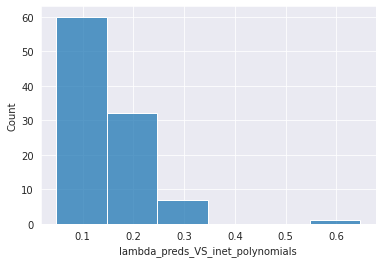

In [33]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

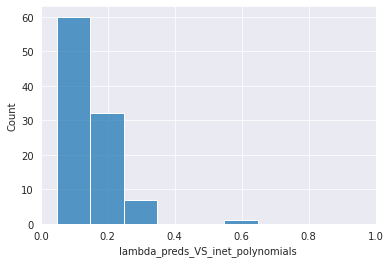

In [34]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


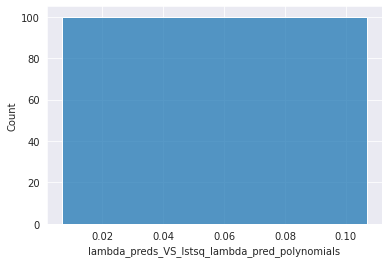

In [35]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

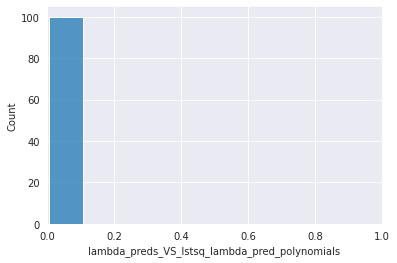

In [36]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


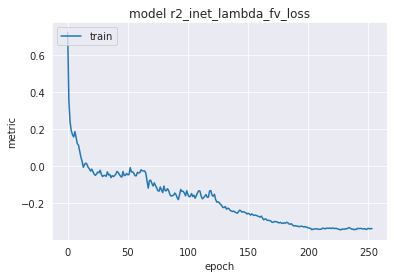

In [37]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


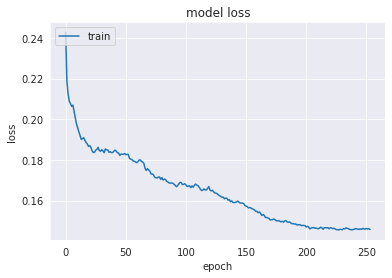

In [38]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [39]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [40]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [41]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [42]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
        print(polynomial_dict_test_list[-1][key][index])
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
        print(polynomial_dict_test_list[-1][key][index])
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


0.0937*a**3 + 0.0307*a**2*b - 0.074*a**2*c - 0.0308*a**2*d - 0.0366*a**2*e - 0.1143*a**2 + 0.0718*a*b**2 - 0.0653*a*b*c + 0.0572*a*b*d - 0.2939*a*b*e - 0.1168*a*b + 0.3513*a*c**2 - 0.0405*a*c*d - 0.1539*a*c*e + 0.3473*a*c + 0.0162*a*d**2 - 0.0152*a*d*e + 0.0126*a*d - 0.0038*a*e**2 + 0.0977*a*e - 0.0284*a - 0.0123*b**3 + 0.1061*b**2*c + 0.1448*b**2*d - 0.1879*b**2*e - 0.0738*b**2 - 0.0595*b*c**2 - 0.31*b*c*d + 0.0365*b*c*e - 0.0366*b*c + 0.0848*b*d**2 - 0.0377*b*d*e - 0.2749*b*d + 0.2279*b*e**2 + 0.4521*b*e + 0.0663*b + 0.1182*c**3 - 0.0526*c**2*d - 0.0197*c**2*e - 0.0234*c**2 - 0.0186*c*d**2 + 0.0171*c*d*e + 0.046*c*d + 0.0029*c*e**2 + 0.0627*c*e - 0.1046*c - 0.0156*d**3 - 0.0357*d**2*e - 0.0053*d**2 - 0.005*d*e**2 + 0.0598*d*e + 0.0398*d + 0.032*e**3 + 0.0713*e**2 - 0.1615*e + 0.0263

[ 0.09374086  0.03067949 -0.07398257 -0.03079829 -0.03656986 -0.11429747
  0.07179489 -0.06530322  0.05716825 -0.29394057 -0.11675628  0.35133877
 -0.04048592 -0.15390144  0.34734116  0.01616951 -0.01522511  0.01264043
 -0.00381645  0.09769433 -0.02844567 -0.01231112  0.10609066  0.14478649
 -0.18785546 -0.0737671  -0.05948973 -0.30995692  0.03652808 -0.03663184
  0.08480818 -0.03768361 -0.27486871  0.22786934  0.45207564  0.06633005
  0.11822153 -0.05259808 -0.01967347 -0.02339678 -0.0185817   0.01711717
  0.0459745   0.00286569  0.06272277 -0.10461521 -0.01562473 -0.03566238
 -0.00528557 -0.00496247  0.05979677  0.03975152  0.03203763  0.07129746
 -0.16148006  0.02626117]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_target_polynomials


-0.0266*a**3 + 0.0146*a**2*b + 0.0116*a**2*c - 0.0039*a**2*d + 0.0046*a**2*e + 0.007*a**2 - 0.0065*a*b**2 + 0.0104*a*b*c + 0.0068*a*b*d - 0.3612*a*b*e - 0.0253*a*b + 0.5353*a*c**2 - 0.0002*a*c*d + 0.0028*a*c*e - 0.0107*a*c + 0.0025*a*d**2 - 0.0031*a*d*e - 0.0005*a*d - 0.0005*a*e**2 - 0.0115*a*e + 0.0115*a + 0.0053*b**3 - 0.0157*b**2*c - 0.0046*b**2*d - 0.0162*b**2*e + 0.007*b**2 + 0.0177*b*c**2 - 0.4033*b*c*d - 0.0047*b*c*e - 0.0024*b*c + 0.0031*b*d**2 - 0.0087*b*d*e + 0.0044*b*d + 0.5552*b*e**2 + 0.0254*b*e - 0.0034*b + 0.0127*c**3 + 0.0025*c**2*d - 0.0022*c**2*e - 0.0266*c**2 + 0.0104*c*d**2 - 0.0098*c*d*e - 0.0054*c*d + 0.0082*c*e**2 - 0.0063*c*e + 0.0202*c + 0.0053*d**3 - 0.0056*d**2*e - 0.015*d**2 + 0.0039*d*e**2 + 0.0087*d*e + 0.0065*d - 0.0132*e**3 + 0.0157*e**2 - 0.0035*e - 0.006

[-2.66286207e-02  1.45601872e-02  1.16439873e-02 -3.88408229e-03
  4.61436649e-03  6.99583599e-03 -6.54467003e-03  1.03812315e-02
  6.80728656e-03 -3.61193378e-01 -2.52544188e-02  5.35344507e-01
 -1.75747170e-04  2.79186522e-03 -1.06541601e-02  2.53321422e-03
 -3.10165214e-03 -4.69949848e-04 -4.94762984e-04 -1.15002404e-02
  1.15467449e-02  5.34134081e-03 -1.56617909e-02 -4.62439120e-03
 -1.62397733e-02  6.99865239e-03  1.77476882e-02 -4.03271771e-01
 -4.74963380e-03 -2.35562782e-03  3.05506918e-03 -8.71938447e-03
  4.42957112e-03  5.55219213e-01  2.53765131e-02 -3.41258209e-03
  1.26718512e-02  2.53460882e-03 -2.21208134e-03 -2.65984034e-02
  1.03806472e-02 -9.80648094e-03 -5.38152986e-03  8.22730876e-03
 -6.31276451e-03  2.02034217e-02  5.26151250e-03 -5.56613450e-03
 -1.49767373e-02  3.87058420e-03  8.69746377e-03  6.54307562e-03
 -1.31720538e-02  1.56682979e-02 -3.50438299e-03 -6.04576343e-03]
-----------------------------------------------------------------------------------------

-0.0143*a**3 - 0.3763*a*b*e + 0.5458*a*c**2 - 0.4004*b*c*d + 0.5664*b*e**2

[-0.01427083  0.          0.          0.          0.          0.
  0.          0.          0.         -0.37627228  0.          0.54584296
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.40039894  0.          0.
  0.          0.          0.          0.56639683  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


-0.0399999991059303*a*c + 0.14190000295639*b*c + 0.116499997675419*c**3 + 0.00789999961853027*e**3 - 0.0197999998927116

[ 0.00788006  0.11646574 -0.01984406 -0.03998315  0.14189014  0.01779204
  0.01858689  0.01774429  0.01791505  0.01780285  0.01808907  0.01674558
  0.01724706  0.01873781  0.01795402  0.01783848  0.0185649   0.01835199
  0.01766489  0.01778904  0.01765144  0.01789133  0.01773783  0.01796574
  0.01793886  0.01659997  0.01719578  0.01739608  0.01799029  0.01783684
  0.01751271  0.01854367  0.01715407  0.01801678  0.01791004  0.01876477
  0.01800442  0.01735443  0.01761618  0.01811454  0.01748994  0.01743376
  0.01794944  0.01783702  0.01817067  0.01798757  0.01791733  0.01730439
  0.01795855  0.01757069  0.01868862  0.01724581  0.0178763   0.01799566
  0.01853412  0.01726128  0.01793517  0.01883218  0.0181528   0.01846174
  0.01737723  0.01837975  0.01772532  0.01832429  0.01828267  0.01732074
  0.01746181  0.01765238  0.01804597  0.01743865  0.0188094   0.01777963
  0.01844053  0.01740079  0.01752464  0.01832777  0.01811645  0.0178352
  0.01798042  0.01754299  0.01708294  0.01807739  0.

0.0640000000000000

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


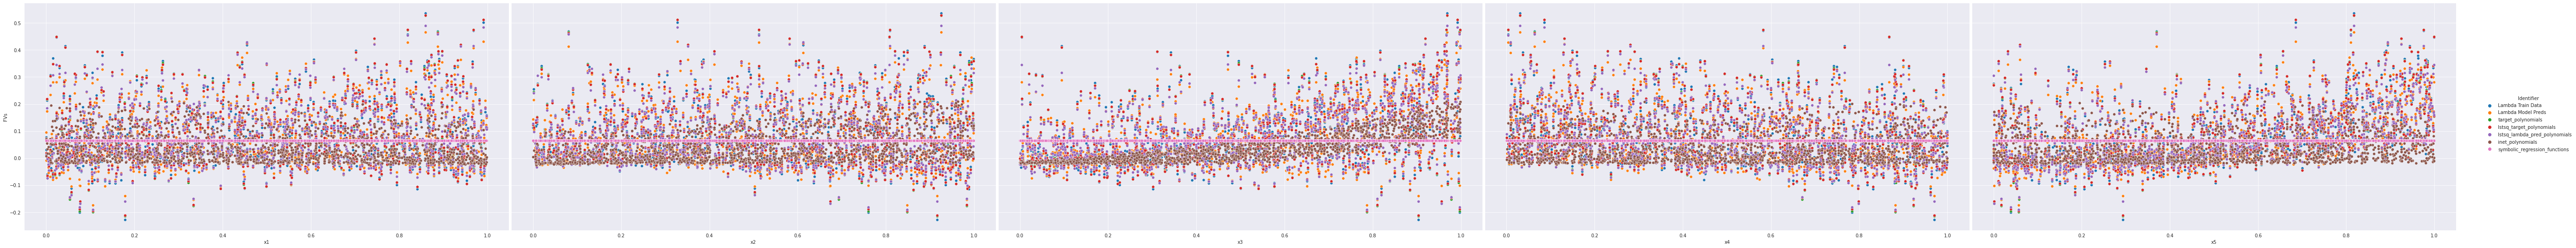

In [43]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

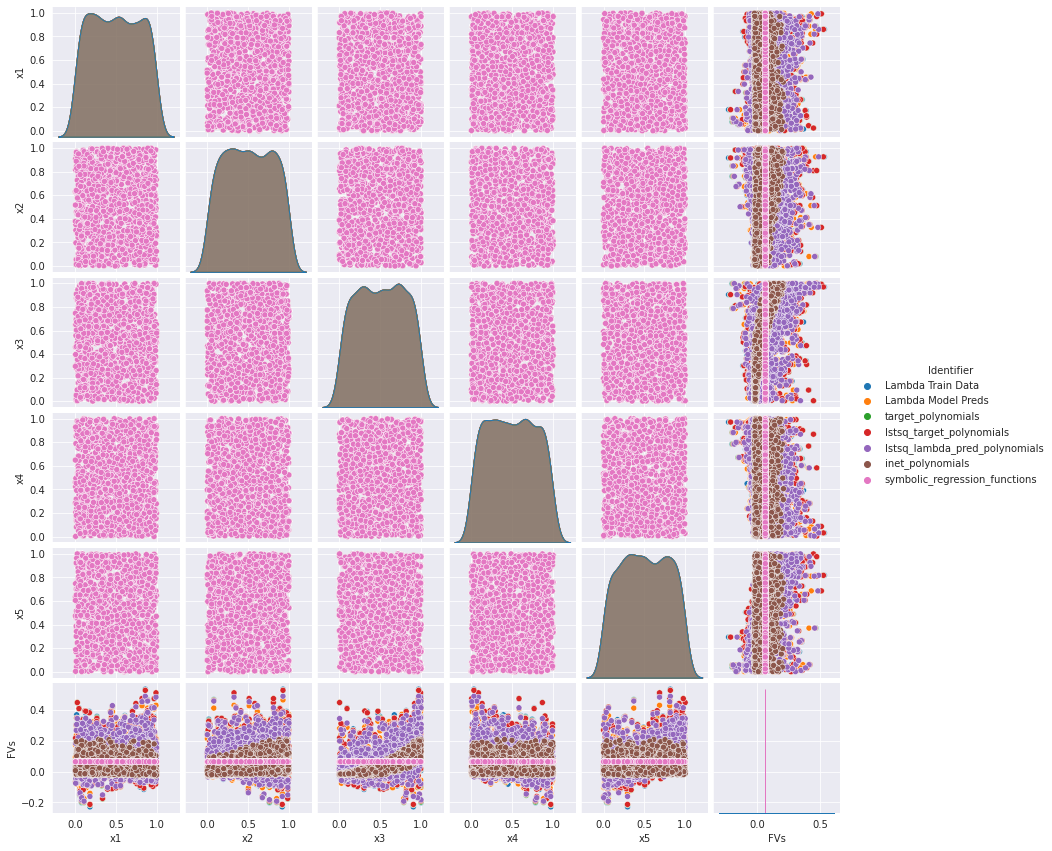

In [44]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

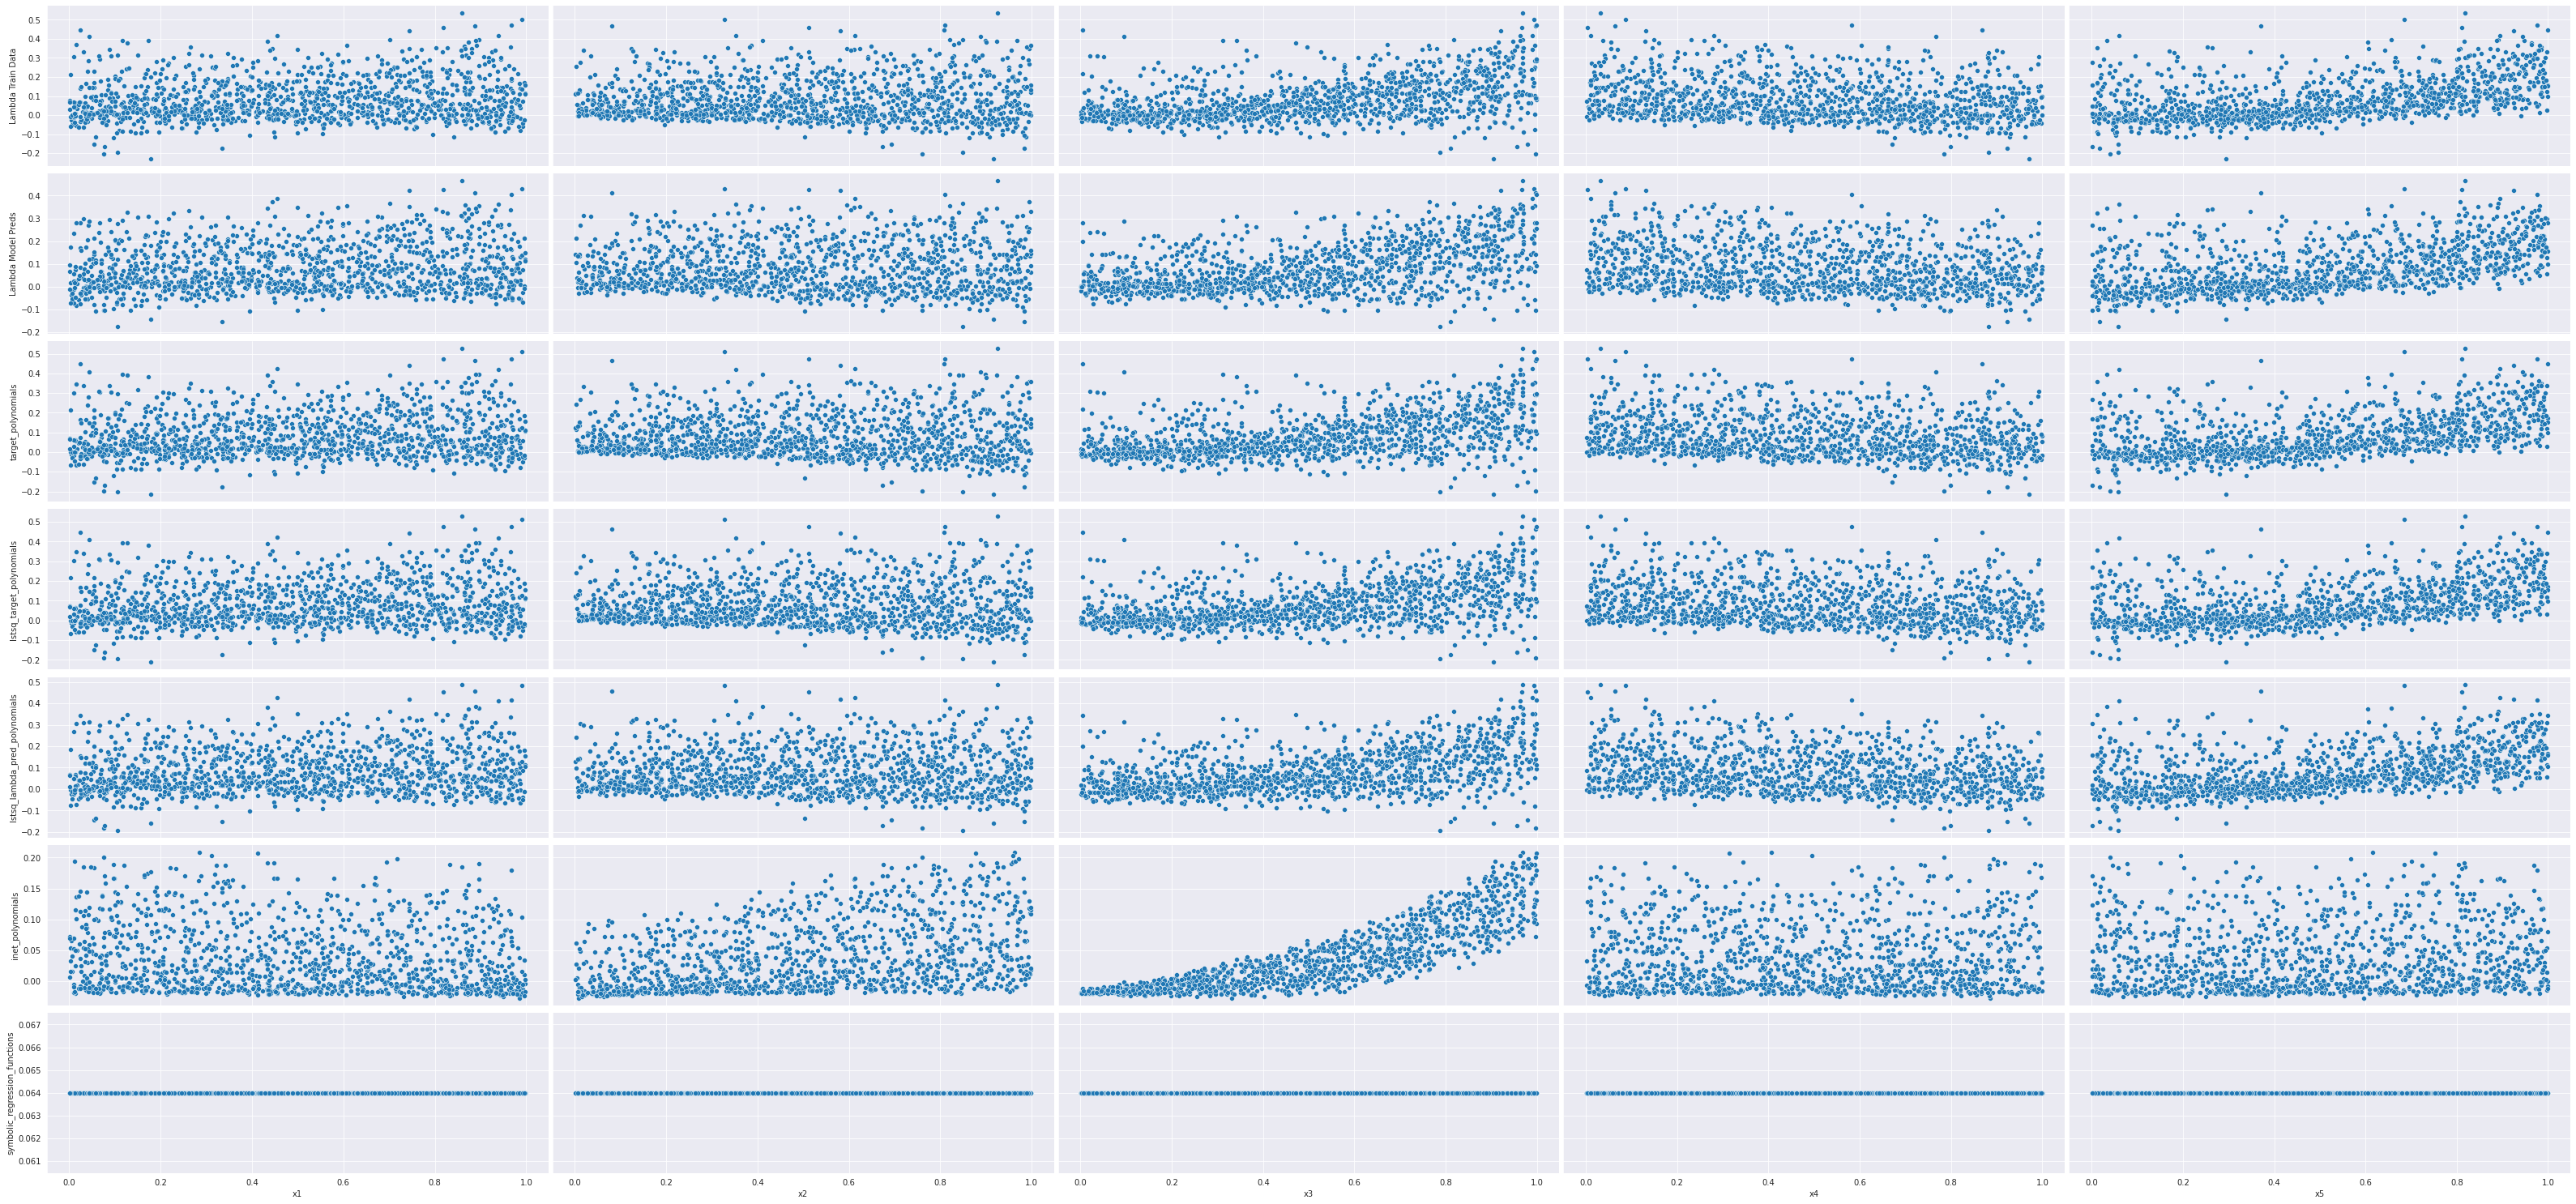

In [45]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [46]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [47]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s


True


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.3s finished


In [48]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 4.9878


In [49]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 10.9492


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [50]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.3s finished


In [51]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 0.3481


In [52]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [53]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


NEW


TypeError: in user code:

    ../utilities/utility_functions.py:1374 function_to_optimize  *
        poly_optimize_fv_list = tf.vectorized_map(calculate_poly_fv_tf_wrapper(list_of_monomial_identifiers_numbers, poly_optimize, config=config), (random_lambda_input_data))

    TypeError: tf__calculate_poly_fv_tf_wrapper() missing 1 required positional argument: 'current_monomial_degree'


# Evaluate Real Dataset


##  Auto MPG-Dataset

In [ ]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [ ]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()